# Анализ поведения клиентов  сети фитнес-центров «Культурист-датасаентист» с целью определения стратегии взаимодействия 

<font size = 5> ***Цель исследования:*** </font>

<font size = 4>Провести анализ поведения клиентов сети фитнес-центров «Культурист-датасаентист» для определения стратегии взаимодействия  </font> 

<font size = 5>***Задачи:***</font>

* <font size = 4 > Построить модель прогнозирования оттока клиентов; </font>  
* <font size = 4 > Провести кластеризацию клиентов;</font>
* <font size = 4 > На основе полученных данных предложить базовые рекомендации по работе с клиентами.</font>

# Содержание
* **1 [Загрузка данных](#1)**
* **2 [Исследовательский анализ данных (EDA)](#2)**
  * **2.1  [Изучаем средние значения и стандартные отклонения](#21)**
  * **2.2  [Изучаем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался](#22)**
  * **2.3  [Строим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)](#23)**
  * **2.4  [Строим и визуализируем матрицу корреляций ](#24)**
* **3  [Модель прогнозирования оттока клиентов](#3)**
* **4 [Кластеризация клиентов](#4)**
  * **4.1 [Стандартизируем данные](#41)**
  * **4.2 [Строим дендрограмму](#42)**
  * **4.3 [Обучаем модель кластеризации на основании алгоритма K-Means](#43)**
  * **4.4 [Оцениваем средние значения признаков для кластеров ](#44)**
  * **4.5 [Считаем долю оттока для каждого кластера](#45)**
* **5 [Выводы](#5)**
* **6 [Базовые рекомендации по работе с клиентами](#6)**


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

<a id='1'></a>
## Загрузка данных

In [2]:
df=pd.read_csv('/datasets/gym_churn.csv')
print(df.shape)
display(df.head())
print(df.info())

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Вывод:** На первый взгляд существенных проблем в данных нет:

        * нет пропущенных значений;
        
        * нет данных в форматах object и bool.
        
    Для удобства приведем названия столбцов к нижнему регистру и изменим тип данных в столбце Month_to_end_contract к int. 

In [3]:
df.columns=df.columns.str.lower()
df['month_to_end_contract']=df['month_to_end_contract'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

<a id='2'></a>
## Исследовательский анализ данных (EDA)

<a id='21'></a>
### Изучаем средние значения и стандартные отклонения

Описывать средние значения будем только для "исчисляемых" переменных: 
   * 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
   * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
   * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
   * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
   * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон, 
   * 'Age' - возраст;
   * 'Lifetime' - время с момента первого обращения в фитнес-центр (в месяцах).

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Вывод:** 
  * средняя длительность текущего абонемента: 4,7 месяца, у половины клиентов длительность текущего абонемента от 1 до 6 месяцев (максимальное и минимальное значение скорее всего соответствуют наименьшей и наибольшей длительности из возможных - годовой и месячный абонементы);
  * средний срок до окончания текущего абонемента: 4,3 месяца, у половины клиентов длительность текущего абонемента от 1 до 6 месяцев;
  * средняя частота посещений в неделю за все время посещения центра - 1,9, половина клиентов посещают центр от 1 до 3 раз в неделю; 
  * средняя частота посещений в неделю за последний месяц - 1,8, за последний месяц половина клиентов посещали центр от 1 до 3 раз в неделю;
  * средняя сумма сопутствующих покупок 147 (не указаны единицы измерения рубли/доллары и т.п., но для данного исследования это не имеет значения), половина клиентов потратили от 69 до 211;
  * среднее время с момента первого обращения в фитнес-центр - 3,7, половина клиентов посещают центр на протяжении 1 - 5 месяцев. Самый 'старый' клиент посещает центр на протяжении 31 месяца;
  * средний возраст клиентов - 29 лет, половина клиентов в возрасте от 27 до 31 года. Самому младшему 18 лет, старшему - 41 год. 
  
  Теперь посмотрим эти значения в группах оставшихся и ушедших клиентов. 

<a id='22'></a>
### Изучаем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [5]:
data=df.groupby('churn').mean()
display(data.T)

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Вывод:** После разделения на группы различия сразу стали видны:
* средняя длительность текущего абонемента у оставшихся клиентов - 6 месяцев, у ушедших 1,7 месяца;
* средний срок до окончания текущего абонемента: у оставшихся клиентов 5 месяцев, среди ушедших 1,7 месяца;  
* средняя частота посещений в неделю за все время посещения центра - 2 раза среди оставшихся клиентов, 1,5 среди ушедших; 
* средняя частота посещений в неделю за последний месяц - 2 раза у оставшихся клиентов, среди ушедших 1 раз;
* средняя сумма сопутствующих покупок у оставшихся клиентов - 158, среди ушедших - 115. 
* среднее время с момента первого обращения в фитнес-центр среди оставшихся клиентов - 4,7 месяца, среди ушедших 1 месяц;
* средний возраст оставшихся клиентов - 29 лет, ушедших - 27 лет.  
  Далее визуализируем распределение признаков, посмотрим какие еще особенности получится выявить. 

<a id='23'></a>
### Строим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

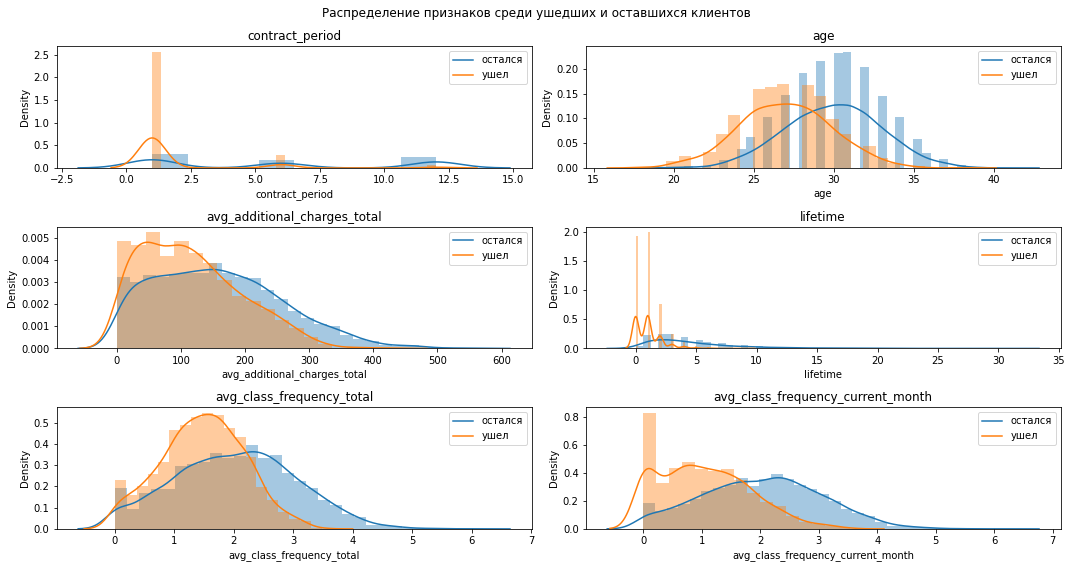

In [6]:
signs=['contract_period', 'age','avg_additional_charges_total', 'lifetime', 
       'avg_class_frequency_total', 'avg_class_frequency_current_month']
cat=['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

col_count, row_count = 2,3
plt.figure(figsize=(15, 8))

for i, n in enumerate(signs):
    for churn in df['churn'].unique():
        cur=df.query('churn==@churn')
        sns.distplot(cur[n], ax=plt.subplot(row_count, col_count, i+1))
    plt.title(n)
    plt.legend(labels=['остался', 'ушел'])
plt.suptitle('Распределение признаков среди ушедших и оставшихся клиентов')

plt.tight_layout()







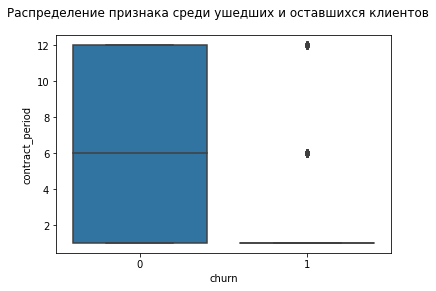

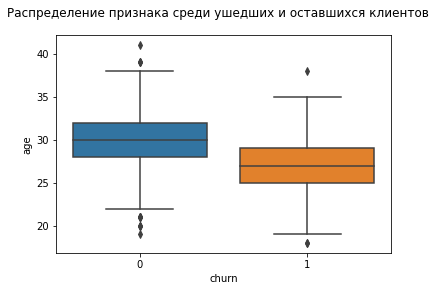

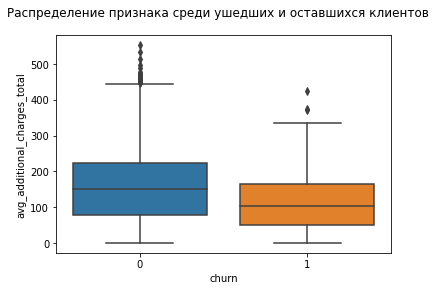

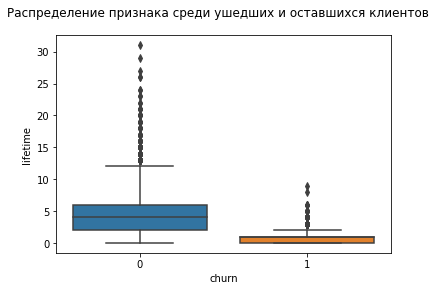

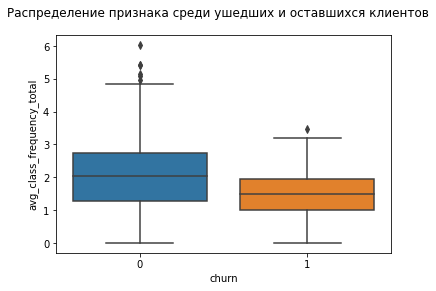

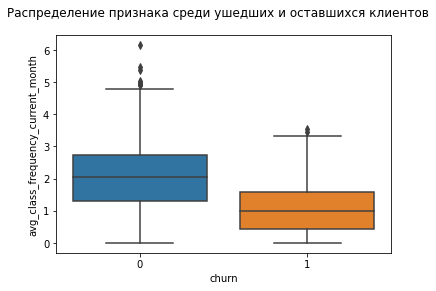

In [7]:
for i in signs:
    sns.boxplot(x=df['churn'] , y=df[i], data=df)
    plt.suptitle('Распределение признака среди ушедших и оставшихся клиентов')
    plt.show()

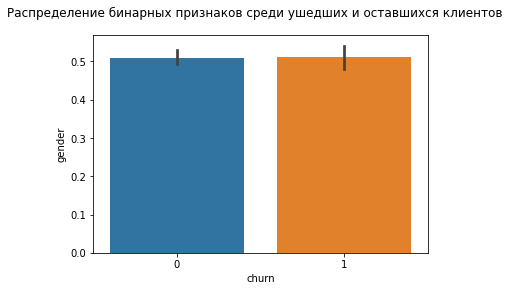

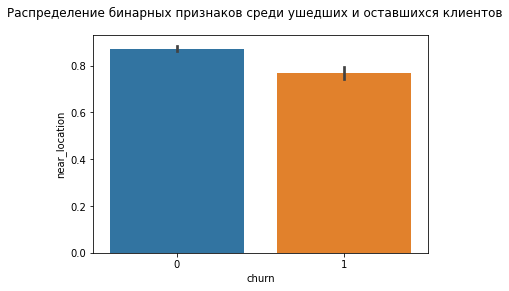

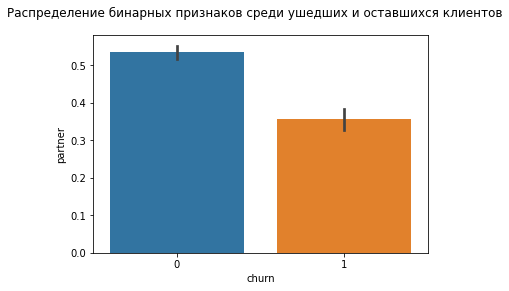

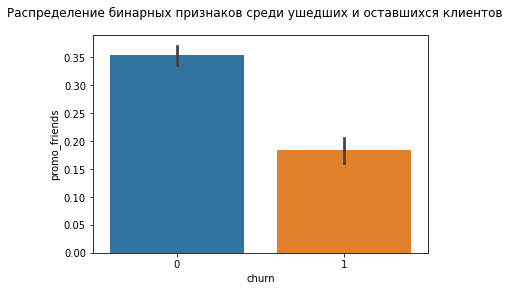

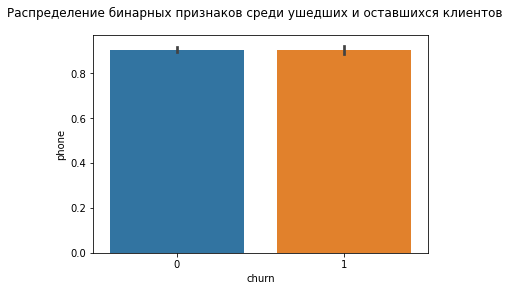

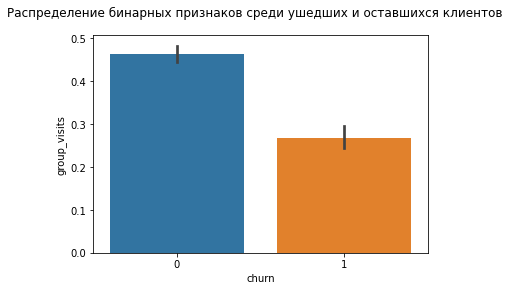

In [8]:
for i in cat:
    sns.barplot(x=df['churn'] , y=df[i], data=df)
    plt.suptitle('Распределение бинарных признаков среди ушедших и оставшихся клиентов')
    plt.show()


**Вывод:** Уже на этом этапе можно предположить какие признаки могут указывать на потенциальный отток клиентов: 
* длительность текущего абонемента;
* общая продолжительность посещения клуба;
* частота посещения центра (особенно в последний месяц);
* дополнительные покупки;
* посещение групповых тренировок;
* посетители пришедшие от партнеров и клиентов клуба. 

Такие показатели как пол и оставленный номер телефона предположительно не влияют на отток клиентов. 

Построим матрицу корреляций и выделим не влияющие признаки, а также признаки, влияющие друг на друга. 

<a id='24'></a>
### Строим и визуализируем матрицу корреляций 

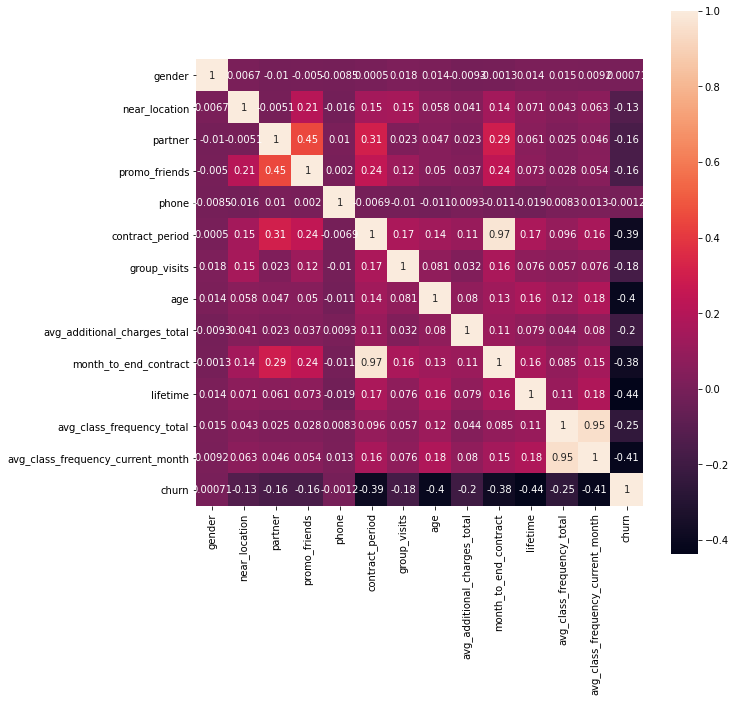

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

**Вывод:** Как мы и предполагали пол и оставленный номер телефона имеют наименьшее влияние на отток клиентов, наибольшее влияние судя по графику имеют общая продолжительность посещения центра и частота посещения клуба в последний месяц. 

Среди признаков были выявлены две пары признаков влияющих друг на друга:
* недельная частота посещения центра в целом и недельная частота посещения в последний месяц;
* длительность абонемента и остаток до конца абонемента. 

Это логично и было ожидаемо. Теперь нужно выбрать признаки, которые мы не будем учитывать при проведении машинного обучения. Предлагаю удалить частоту посещений в неделю за все время, так как коффициент корреляции этого признака с оттоком меньше, чем у недельной частоты посещения в последний месяц. 
Также предлагаю удалить количество месяцев до конца абонемента, так как длительность абонемента, как мне кажется более простой признак (вообще, я бы посоветовалась со специалистами, которые предоставляют данные, какие на их взгляд данные удобнее выгружать).


In [10]:
data=df.drop(['avg_class_frequency_total','month_to_end_contract'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   lifetime                           4000 non-null   int64  
 10  avg_class_frequency_current_month  4000 non-null   float64
 11  churn                              4000 non-null   int64

<a id='3'></a>
## Модель прогнозирования оттока клиентов

Приступаем к подготовке данных для машинного обучения

In [11]:
#Делим данные на признаки и целевую переменную 
x = data.drop(['churn'], axis=1)
y = data['churn'] 

#проводим разделение на обучающую и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y)

Теперь обучим модель логистической регрессией:

In [12]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
probabilities = model.predict_proba(x_test)[:,1]
#рассчитываем метрики
def metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

metrics(y_test, predictions,probabilities,
        title='Метрики для модели логистической регрессии:')


Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.82
	F1: 0.83
	ROC_AUC: 0.97


Теперь обучим модель случайным лесом:

In [13]:
#clf = RandomForestClassifier()
#parametrs = { 'n_estimators': range (10, 51, 10),
              #'max_depth': range (1,13, 2),
              #'min_samples_leaf': range (1,8),
              #'min_samples_split': range (2,10,2) }
#grid = GridSearchCV(clf, parametrs, cv=5)
#grid.fit(x_train, y_train)

In [14]:
t_model = RandomForestClassifier(random_state=0)
t_model.fit(x_train, y_train)
t_predictions = t_model.predict(x_test)
t_probabilities = t_model.predict_proba(x_test)[:, 1]

metrics(y_test, t_predictions,t_probabilities,
        title='Метрики для модели случайный лес:')


Метрики для модели случайный лес:
	Accuracy: 0.90
	Precision: 0.85
	Recall: 0.77
	F1: 0.81
	ROC_AUC: 0.96


**Вывод:** Оптимальный алгоритм для обучения модели - логическая регрессия, он опережает случайный лес по всем метрикам.  

<a id='4'></a>
## Кластеризация клиентов

<a id='41'></a>
### Стандартизируем данные 

Метод кластеризации лучше работает на стандартизированных данных, поэтому необходимо провести предварительную стандартизацию.  

In [15]:
scaler = StandardScaler() 
x_st = scaler.fit_transform(x)

<a id='42'></a>
### Строим дендрограмму 

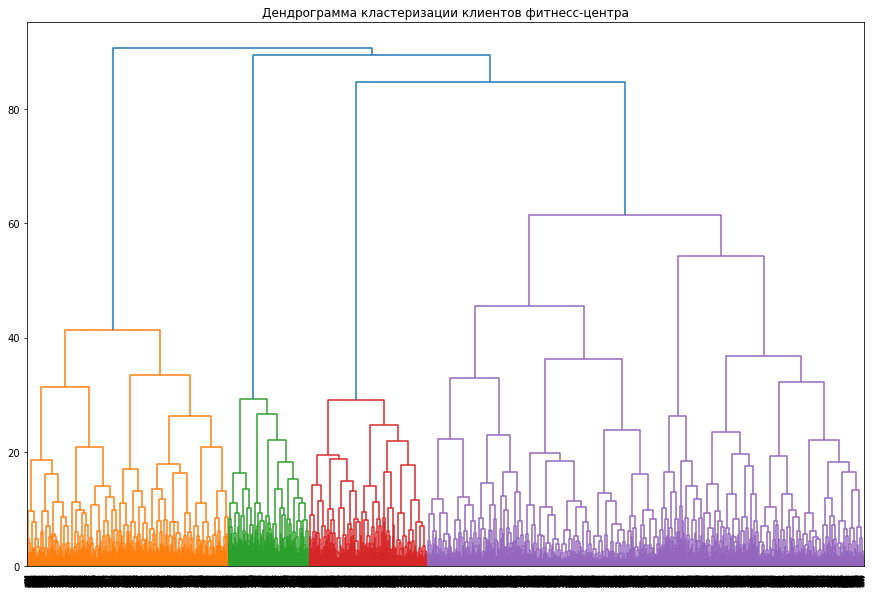

In [16]:
linked = linkage(x_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации клиентов фитнесс-центра')
plt.show() 

**Вывод:** Можно провести линию на уровне между 35 и 40 и получить 8 кластеров, но для нашей задачи, это слишком много, к тому же в задании указано, что количество кластеров должно быть равно 5. Поэтому подведем черту на уровне 50 и разделим выборку на 5 кластеров. 

<a id='43'></a>
### Обучаем модель кластеризации на основании алгоритма K-Means

In [17]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_st)

# сохраним метки кластера в поле нашего датасета
data['cluster_km'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_st, labels)))

Silhouette_score: 0.14


**Выводы:** Значение метрики не очень высокая, значит результаты кластеризации нужно будет дополнительно обсудить.  

<a id='44'></a>
### Оцениваем средние значения признаков для кластеров 

Построим графики для отображения признаков. 

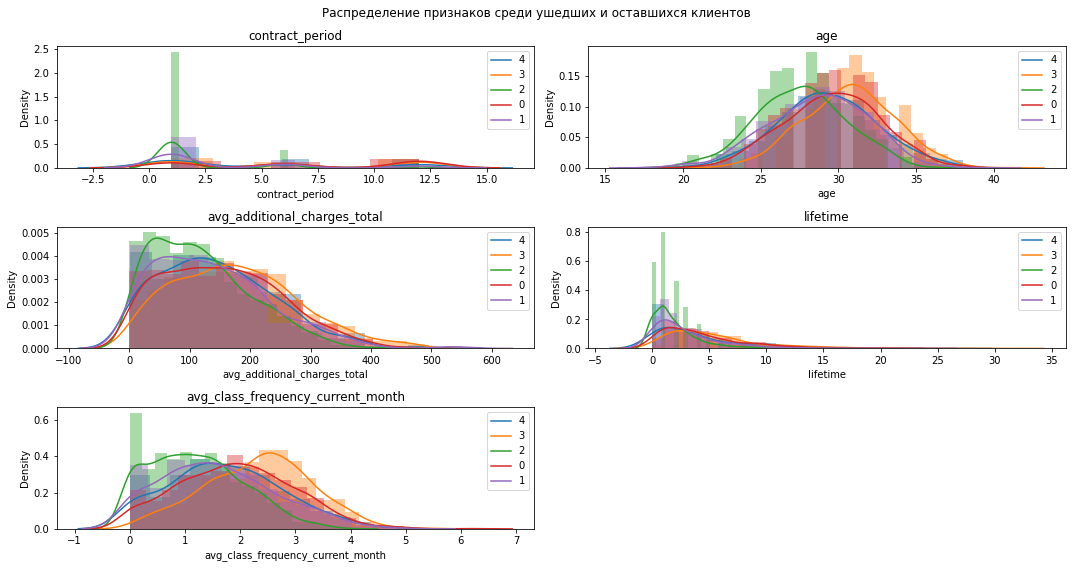

In [18]:
signs=['contract_period', 'age','avg_additional_charges_total', 'lifetime', 
       'avg_class_frequency_current_month']
cat=['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
 
col_count, row_count = 2,3
plt.figure(figsize=(15, 8))

for i, n in enumerate(signs):
    for cluster_km in data['cluster_km'].unique():
        cur=data.query('cluster_km==@cluster_km')
        sns.distplot(cur[n], ax=plt.subplot(row_count, col_count, i+1))
    plt.title(n)
    plt.legend(labels=data['cluster_km'].unique())
plt.suptitle('Распределение признаков среди ушедших и оставшихся клиентов')

plt.tight_layout()


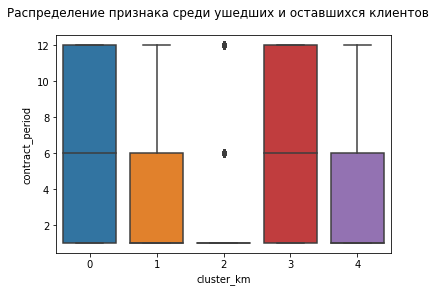

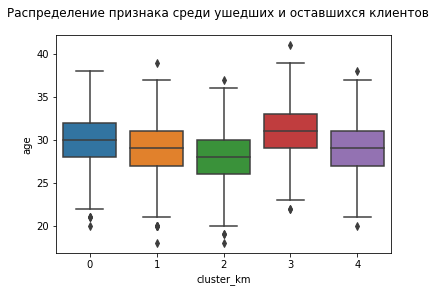

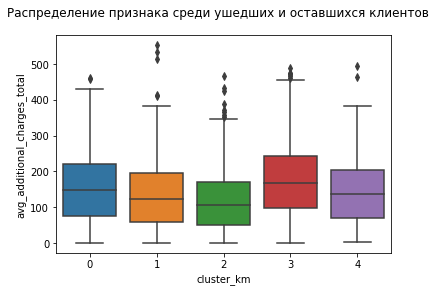

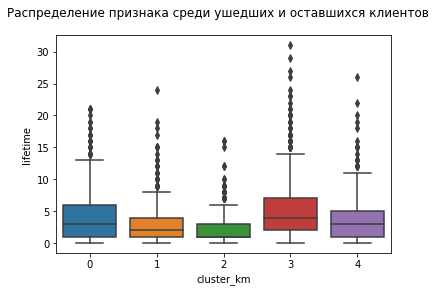

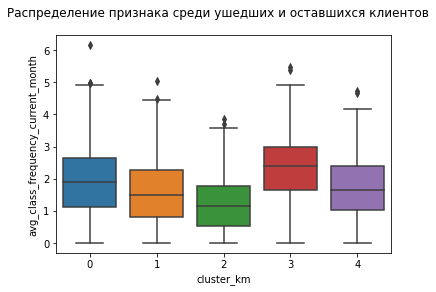

In [19]:
for i in signs:
    sns.boxplot(x=data['cluster_km'] , y=data[i], data=data)
    plt.suptitle('Распределение признака среди ушедших и оставшихся клиентов')
    plt.show()

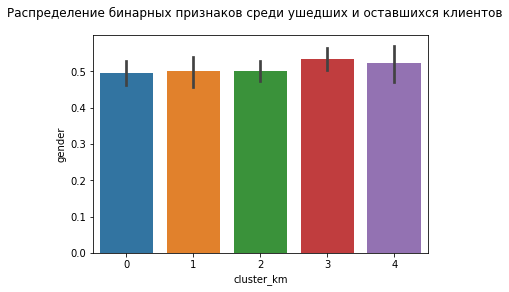

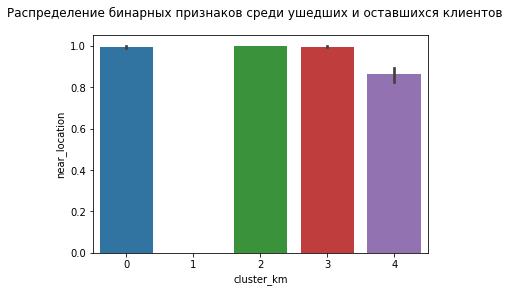

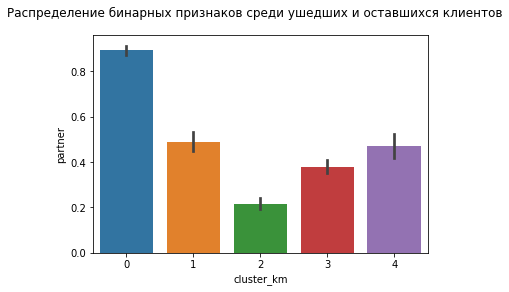

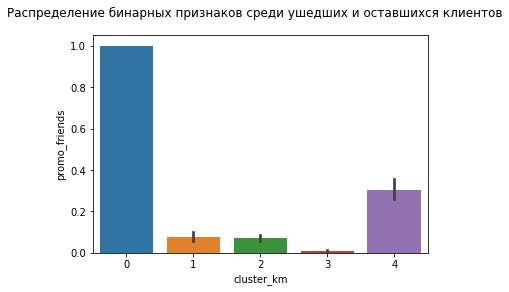

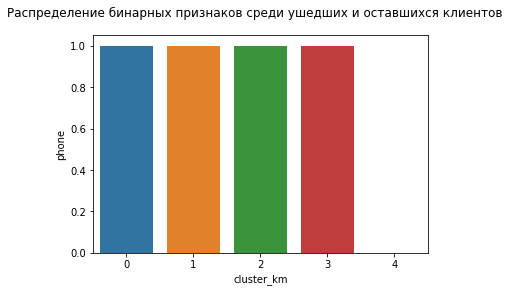

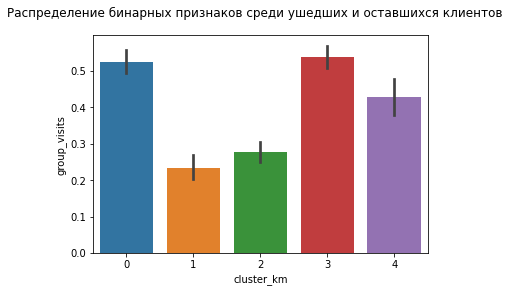

In [20]:
for i in cat:
    sns.barplot(x=data['cluster_km'], y=data[i], data=data)
    plt.suptitle('Распределение бинарных признаков среди ушедших и оставшихся клиентов')
    plt.show()

**Вывод:** Наибольшие различия в кластерах видны по следующим признакам: 
* продолжительность действия абонемента 
* недельная частота посещений в последний месяц
* проживание вблизи центра
* приглашение друга или от компании партнера
* посещение групповых тренировок
* одна группа явно выделяется по признаку - предоставленный номер телефона

Теперь посчитаем долю оттока и опишем каждую группу клиентов подробнее.

<a id='45'></a>
### Считаем долю оттока для каждого кластера 

In [21]:
data_m=data.groupby('cluster_km').mean()
display(data_m.T)

cluster_km,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


Так как в столбце 'churn' значения представлены 0 и 1, где 1 - ушедший клиент, при вызове функции среднее арифметическое мы получаем долю ушедших клиентов. К тому же такая таблица очень удобна для описания кластеров. 

**Описание кластеров:**
    
  *  **Максимальный отток - 56%**
     * средний возраст 28 лет;
     * дополнительные траты - 119 - наименьший показатель среди всех групп;
     * за последний месяц посещали фитнесс-центр в среднем 1 раз в неделю - наименьший показатель среди всех групп;
     * средняя продолжительность действия абонемента - 2 месяца - наименьший показатель из всех групп;
     * групповые тренировки посещали всего 28% клиентов; 
     * все проживают в районе фитнесс-центра;
     * пришли от партнера - 22% клиентов - наименьший показатель среди всех групп;
     * все оставили контактный номер телефона;
     * 7% пришли по приглашению друзей. 
     * *Таким образом это клиенты, решившие попробовать занятия спортом. Они покупают месячные абонементы, выбирают ближайший к дому центр, не тратят деньги на дополнительные услуги (например, спецпитание или массаж, которые востребованы у людей увлекающихся спортом), они не участвуют в программах лояльности 'партнеры клуба' и 'приведи друга'* 
     
     **заинтересовать этих клиентов будет не просто и дополнительные затраты на повышение лояльности скорее всего не окупятся**
     
     
   *  **Отток на уровне - 40%**
      * средний возраст 29 лет;
      * дополнительные траты - 144;
      * за последний месяц посещали фитнесс-центр в среднем 1.6 раза в неделю;
      * средняя продолжительность действия абонемента - 3 месяца;
      * групповые тренировки посещали всего 23% клиентов - наименьший показатель среди групп; 
      * не проживают в районе фитнесс-центра;
      * пришли от партнера - 50% клиентов;
      * все оставили контактный номер телефона;
      * 8% пришли по приглашению друзей;
      * в среднем посещают центр уже 3 месяца.
     
     *Это клиенты, по большей части пришедшие по программам лояльности. Они покупают более длительные абонементы, не охотно тратят деньги на дополнительные услуги. Для этой группы нужно выяснить условия программ лояльности (например, на момент покупки были скидки на абонементы продолжительностью действия более 2 месяцев).* 
     
     **Больше похоже на то, что эта группа 'экономных клиентов' и привлечь их можно скидками, например на покупку следующего абонемента длительного срока действия**  
     
     
   *  **Отток на уровне - 27%**
      * средний возраст 29 лет;
      * дополнительные траты - 144;
      * за последний месяц посещали фитнесс-центр в среднем 1,7 раза в неделю;
      * средняя продолжительность действия абонемента - 5 месяцев;
      * групповые тренировки посещали всего 43% клиентов; 
      * 86% проживают в районе фитнесс-центра;
      * пришли от партнера - 47% клиентов;
      * никто из них не оставил контактный номер телефона;
      * 3% пришли по приглашению друзей;
      * в среднем посещают центр уже 4 месяца.
     
     * Эти клиенты покупают более длительные абонементы, тратят деньги на дополнительные услуги. Участвуют в программах лояльности, посещают групповые тренировки* 
     
     **Этих клиентов можно отнести к категории любителей и привлечь их можно скидками, а также заинтересовать групповыми занятиями - предлагать пробные занятия в каждом направлении, можно уговорить оставить номер телефона  для оповещения по интересным событиям в центре (приглашенные мастера, тематические праздники и т.п. )**  
     
     
     
   *  **Отток на уровне - 12%**
      * средний возраст 30 лет;
      * дополнительные траты - 153 - чуть больше, чем у предыдущей группы;
      * за последний месяц посещали фитнесс-центр в среднем 2 раза в неделю;
      * средняя продолжительность действия абонемента - 7 месяцев;
      * групповые тренировки посещали всего 52% клиентов; 
      * 99% проживают в районе фитнесс-центра;
      * пришли от партнера - 90% клиентов;
      * никто из них не оставил контактный номер телефона;
      * 100% пришли по приглашению друзей;
      * в среднем посещают центр уже 4 месяца.
     
     *Эта группа клиентов обладает высокой лояльностью, они покупают длительные абонементы, тратят деньги на дополнительные услуги. Участвуют в программах лояльности, посещают групповые тренировки* 
     
     **Этих клиентов можно удерживать в программах лояльности, заинтересовать инетересными групповыми тренировками**   
     
*  **Минимальный отток - 1,5%**
     * средний возраст 31 год;
     * дополнительные траты - 176 - наибольший показатель среди всех групп;
     * за последний месяц посещали фитнесс-центр в среднем 2,3 раза в неделю - наибольший показатель среди всех групп;
     * средняя продолжительность действия абонемента - 6 месяцев - наибольший показатель из всех групп;
     * групповые тренировки посещали всего 53% клиентов; 
     * 99% проживают в районе фитнесс-центра;
     * пришли от партнера - 38% клиентов - наименьший показатель среди всех групп;
     * все оставили контактный номер телефона;
     * менее 1% пришли по приглашению друзей. 
     
*Это постоянные клиенты, они явно определились с центром и стабильно занимаются спортом*
     
**не стоит дополнительно вкладывать средства на удержание этих клиентов, достаточно поддерживать уровень сервиса на должном уровне и благодарить их за выбор, также можно просить эту группу клиентов оставлять отзывы и метки в социальных сетях** &#128521;     

<a id='5'></a>
## Выводы

* <font size = 4 > Мы выбрали модель прогнозирования оттока клиентов - алгоритм логическая регрессия; </font>  
* <font size = 4 > Провели кластеризацию клиентов, выделили 5 групп клиентов и определились с целевыми группами (отток клиентов на уровне от 12-40%). Так как метод кластеризации не отличается высокой точностью, следует дополнительно обсудить полученные результаты на собрании заинтересованных специалистов. </font>


<a id='6'></a>
## Базовые рекомендации по работе с клиентами

<font size = 4 > Основываясь на результатах проведенного исследования, следует предложить специалистам по маркетингу интересующие клиентов услуги: участие в программах лояльности, увеличение количества компаний партнеров (так как от них приходит большая доля клиентов), привлечение клиентов к групповым тренировкам и скидки на покупку абонементов со сроком действия от 6 месяцев, расширение спектра дополнительных услуг. </font>
    
